# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!


In [25]:
# install package for displaying animation
# !pip install JSAnimation
# !pip install ale-py
# !pip install gym[accept-rom-license]==0.23.1
# !pip install gym[atari,accept-rom-license]==0.23.1
# !pip install progressbar


  Preparing metadata (setup.py) ... done
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12067 sha256=e6d97f290174a62d2712541efb38d62a0be91ba79566fe5c104f06340b5388db
  Stored in directory: /home/sagarnildass/.cache/pip/wheels/bf/e1/19/f3a955a8782b8bf8205c82cf8b0623c683acc0c7b71b41129c
Successfully built progressbar


In [26]:
import matplotlib
import matplotlib.pyplot as plt
import pong_utils
import numpy as np
# render ai gym environment
import gym
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from matplotlib import animation
from IPython import display
from multiprocessing import Process, Pipe
from abc import ABC, abstractmethod
from parallelEnv import parallelEnv
import progressbar as pb
%matplotlib inline

In [2]:
# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

using device:  cuda:0


In [3]:


# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())
# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



In [4]:
def preprocess_single(image, bkg_color = np.array([144, 72, 17])):
    img = np.mean(image[34:-16:2,::2]-bkg_color, axis=-1)/255.
    return img

# convert outputs of parallelEnv to inputs to pytorch neural net
# this is useful for batch processing especially on the GPU
def preprocess_batch(images, bkg_color = np.array([144, 72, 17])):
    list_of_images = np.asarray(images)
    if len(list_of_images.shape) < 5:
        list_of_images = np.expand_dims(list_of_images, 1)
    # subtract bkg and crop
    list_of_images_prepro = np.mean(list_of_images[:,:,34:-16:2,::2]-bkg_color,
                                    axis=-1)/255.
    batch_input = np.swapaxes(list_of_images_prepro,0,1)
    return torch.from_numpy(batch_input).float().to(device)

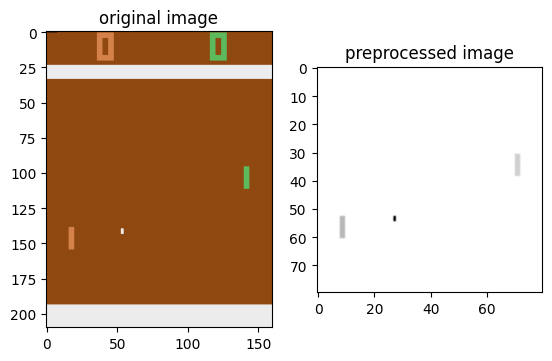

In [5]:

# show what a preprocessed image looks like
env.reset()

_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()



# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [6]:
# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
        
        # 80x80 to outputsize x outputsize
        # outputsize = (inputsize - kernel_size + stride)/stride 
        # (round up if not an integer)
        # 80x80x2 to 38x38x4
        # 2 channel from the stacked frame
        # (80 - 6 + 2)/2 = 38
        self.conv1 = nn.Conv2d(2, 4, kernel_size=6, stride=2, bias=False)

        # 38x38x4 to 9x9x32
        # (38 - 6 + 4)/4 = 9
        self.conv2 = nn.Conv2d(4, 16, kernel_size=6, stride=4)
        self.size=9*9*16
        
        # 2 fully connected layer
        self.fc1 = nn.Linear(self.size, 256)
        self.fc2 = nn.Linear(256, 1)
        
        # Sigmoid to
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
    
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        return self.sig(self.fc2(x))
    

# use your own policy!
policy=Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress

In [7]:
RIGHT=4
LEFT=5

# function to animate a list of frames
def animate_frames(frames):
    plt.axis('off')

    # color option for plotting
    # use Greys for greyscale
    cmap = None if len(frames[0].shape)==3 else 'Greys'
    patch = plt.imshow(frames[0], cmap=cmap)  

    fanim = animation.FuncAnimation(plt.gcf(), \
        lambda x: patch.set_data(frames[x]), frames = len(frames), interval=30)
    
    video = fanim.to_html5_video()
    #display(display_animation(fanim, default_mode='once'))
    html = display.HTML(video)
    display.display(html)
    plt.close()             
    

# play a game and display the animation
# nrand = number of random steps before using the policy
def play(env, policy, time=2000, preprocess=None, nrand=5):
    env.reset()
    
    # start game
    env.step(1)
    
    # perform nrand random steps in the beginning
    for _ in range(nrand):
        frame1, reward1, is_done, _ = env.step(np.random.choice([RIGHT,LEFT]))
        frame2, reward2, is_done, _ = env.step(0)
    
    anim_frames = []
    
    for _ in range(time):
        frame_input = preprocess_batch([frame1, frame2])
        prob = policy(frame_input)
        
        # Right = 4, Left = 5
        action = RIGHT if random.random() < prob else LEFT
        frame1, _, done, _ = env.step(action)
        frame2, _, done, _ = env.step(0)
        
        if preprocess is None:
            anim_frames.append(frame1)
        else:
            anim_frames.append(preprocess(frame1))

        if done:
            break
            
    env.close()
    animate_frames(anim_frames)
    return

In [11]:
play(env, policy, time=100) 

# Rollout
Before we start the training, we need to collect samples. To make things efficient we use parallelized environments to collect multiple examples at once

In [13]:
envs = pong_utils.parallelEnv('PongDeterministic-v4', n=4, seed=12345)

Process Process-2:
Process Process-4:
Process Process-1:
Process Process-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/sagarnildass/anaconda3/envs/mlagents_unity/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/sagarnildass/anaconda3/envs/mlagents_unity/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/sagarnildass/anaconda3/envs/mlagents_unity/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/sagarnildass/anaconda3/envs/mlagents_unity/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sagarnildass/anaconda3/envs/mlagents_unity/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sagarnildass/anaconda3/envs

In [15]:
# collect trajectories for a parallelized parallelEnv object
def collect_trajectories(envs, policy, tmax=200, nrand=5):
    
    # number of parallel instances
    n=len(envs.ps)

    #initialize returning lists and start the game!
    state_list=[]
    reward_list=[]
    prob_list=[]
    action_list=[]

    envs.reset()
    
    # start all parallel agents
    envs.step([1]*n)
    
    # perform nrand random steps
    for _ in range(nrand):
        fr1, re1, _, _ = envs.step(np.random.choice([RIGHT, LEFT],n))
        fr2, re2, _, _ = envs.step([0]*n)
    
    for t in range(tmax):

        # prepare the input
        # preprocess_batch properly converts two frames into 
        # shape (n, 2, 80, 80), the proper input for the policy
        # this is required when building CNN with pytorch
        batch_input = preprocess_batch([fr1,fr2])
        
        # probs will only be used as the pi_old
        # no gradient propagation is needed
        # so we move it to the cpu
        probs = policy(batch_input).squeeze().cpu().detach().numpy()
        
        action = np.where(np.random.rand(n) < probs, RIGHT, LEFT)
        probs = np.where(action==RIGHT, probs, 1.0-probs)
        
        
        # advance the game (0=no action)
        # we take one action and skip game forward
        fr1, re1, is_done, _ = envs.step(action)
        fr2, re2, is_done, _ = envs.step([0]*n)

        reward = re1 + re2
        
        # store the result
        state_list.append(batch_input)
        reward_list.append(reward)
        prob_list.append(probs)
        action_list.append(action)
        
        # stop if any of the trajectories is done
        # we want all the lists to be retangular
        if is_done.any():
            break


    # return pi_theta, states, actions, rewards, probability
    return prob_list, state_list, \
        action_list, reward_list

In [16]:
prob, state, action, reward = pong_utils.collect_trajectories(envs, policy, tmax=100)

In [20]:
print(reward)

[array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([-1., -1.,  0., -1.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 1., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(this is the same as policy_loss except the negative sign)

### REINFORCE
you have two choices (usually it's useful to divide by the time since we've normalized our rewards and the time of each trajectory is fixed)

1. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\log(\pi_{\theta'}(a_t|s_t))$
2. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}$ where $\theta'=\theta$ and make sure that the no_grad is enabled when performing the division

In [18]:
# convert states to probability, passing through the policy
def states_to_prob(policy, states):
    states = torch.stack(states)
    policy_input = states.view(-1,*states.shape[-3:])
    return policy(policy_input).view(states.shape[:-3])

In [21]:
# return sum of log-prob divided by T
# same thing as -policy_loss
def surrogate(policy, old_probs, states, actions, rewards,
              discount = 0.995, beta=0.01):
    
    discount = discount ** np.arange(len(rewards))
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
    
    # convert rewards to future rewards
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10
    
    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    
    # convert everything into pytorch tensors and move to gpu if available
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)
    
    # convert states to policy (or probability)
    new_probs = states_to_prob(policy, states)
    new_probs = torch.where(actions == RIGHT, new_probs, 1.0-new_probs)
    
    ratio = new_probs/old_probs
    
    # include a regularization term
    # this steers new_policy towards 0.5
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    return torch.mean(ratio*rewards + beta*entropy)

In [22]:
Lsur= surrogate(policy, prob, state, action, reward)

print(Lsur)

/tmp/ipykernel_2466/567434260.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  actions = torch.tensor(actions, dtype=torch.int8, device=device)


tensor(0.0069, device='cuda:0', grad_fn=<MeanBackward0>)


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [28]:
episode = 800

widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

# initialize environment
envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
beta = .01
tmax = 320

# keep track of progress
mean_rewards = []

for e in range(episode):
    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
    
    total_rewards = np.sum(rewards, axis=0)
    
    L = -surrogate(policy, old_probs, states, actions, rewards, beta=beta)
    
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    del L
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%50 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()

Episode: 50, score: -14.750000
[-14. -15. -13. -16. -16. -15. -15. -14.]


Episode: 100, score: -14.500000
[-12. -16. -16. -16. -12. -15. -13. -16.]


Episode: 150, score: -14.250000
[-14. -16. -16. -10. -15. -13. -15. -15.]


Episode: 200, score: -13.125000
[-15. -11. -14. -12. -12. -11. -15. -15.]


Episode: 250, score: -12.375000
[-13. -15.  -9. -14. -12. -11. -16.  -9.]


Episode: 300, score: -11.125000
[-13.  -7. -14. -10. -13.  -9. -11. -12.]


Episode: 350, score: -9.000000
[ -8. -10. -12. -12. -12.  -2.  -8.  -8.]


Episode: 400, score: -8.625000
[-10.  -8.  -8. -10.  -4.  -8.  -9. -12.]


Episode: 450, score: -5.000000
[-5. -2. -4. -7. -8. -7. -4. -3.]


Episode: 500, score: -6.375000
[ -3.  -6.  -9.  -5.  -9. -11.  -5.  -3.]


Episode: 550, score: -3.625000
[ 0. -2. -2. -1. -9. -2. -7. -6.]


Episode: 600, score: -3.000000
[-9.  1.  0. -2. -3. -9. -1. -1.]


Episode: 650, score: -2.125000
[-2. -2.  0. -4. -2. -1. -5. -1.]


Episode: 700, score: -1.500000
[-3. -1. -1. -1. -2. -1. -1. -2.]


Episode: 750, score: -1.250000
[-1. -3. -1. -1.  0. -1.  0. -3.]


Episode: 800, score: -0.250000
[-1.  1.  3. -2.  0. -2.  0. -1.]


In [29]:
play(env, policy, time=2000) 

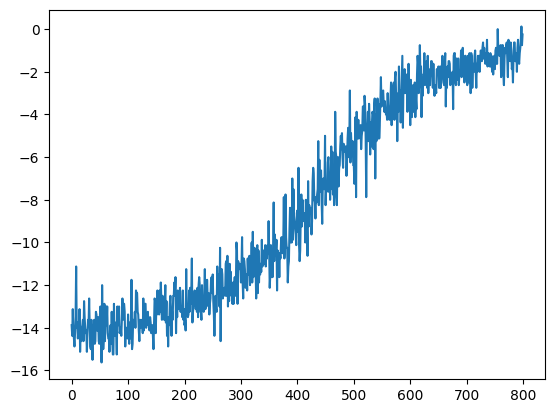

In [30]:
plt.plot(mean_rewards)

In [31]:
# save your policy!
torch.save(policy, 'REINFORCE.policy')

# load your policy if needed
# policy = torch.load('REINFORCE.policy')

# try and test out the solution!
# policy = torch.load('PPO_solution.policy')